In [1]:
import pandas as pd
import numpy as np

from importlib import reload
# import sys

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession

from dtreeviz.trees import dtreeviz, viz_leaf_samples, explain_prediction_path, viz_leaf_criterion

from decty import ShadowDectyTree, viz_leaf_subsamples

In [2]:
spark = SparkSession.builder.getOrCreate()
iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print('X:', X.shape, 'y:', y.shape)

data_pd = pd.DataFrame(
  np.concatenate((X_train, y_train.reshape(len(y_train), 1)), axis=1),
  columns=["sepal_lenght", "sepal_width", "petal_lenght", "petal_width", "class"]
)
data = spark.createDataFrame(data_pd)
data.show(5)

X: (150, 4) y: (150,)
+------------+-----------+------------+-----------+-----+
|sepal_lenght|sepal_width|petal_lenght|petal_width|class|
+------------+-----------+------------+-----------+-----+
|         5.9|        3.0|         4.2|        1.5|  1.0|
|         5.8|        2.6|         4.0|        1.2|  1.0|
|         6.8|        3.0|         5.5|        2.1|  2.0|
|         4.7|        3.2|         1.3|        0.2|  0.0|
|         6.9|        3.1|         5.1|        2.3|  2.0|
+------------+-----------+------------+-----------+-----+
only showing top 5 rows



In [3]:
assembler = VectorAssembler(
    inputCols=["sepal_lenght", "sepal_width", "petal_lenght", "petal_width"],
    outputCol="features")
data = assembler.transform(data)

# Train a DecisionTree model.
dt = DecisionTreeClassifier(
    labelCol="class", featuresCol="features", maxDepth=5, impurity="gini"
)
model = dt.fit(data)

In [4]:
shadow = ShadowDectyTree(
    model,
    X_train,
    y_train,
    target_name='variety',
    feature_names=iris.feature_names,
    class_names=["setosa", "versicolor", "virginica"]  # need class_names for classifier
)

In [5]:
shadow.get_nodes_info()

,left_child,right_child,feat_id,is_leaf,parent_id,is_left,is_right,split_thresh,impurity,prediction,n_samples_in_0,n_samples_in_1,n_samples_in_2,n_samples
0,1,2,2,False,-1,False,False,2.35,0.664700,2.0,37.0,34.0,41.0,112
1,-1,-1,-1,True,0,True,False,-1,0.000000,0.0,37.0,0.0,0.0,37
2,3,8,2,False,0,False,True,4.95,0.495644,2.0,0.0,34.0,41.0,75
3,4,5,3,False,2,True,False,1.65,0.152778,1.0,0.0,33.0,3.0,36
4,-1,-1,-1,True,3,True,False,-1,0.000000,1.0,0.0,32.0,0.0,32
5,6,7,1,False,3,False,True,3.05,0.375000,2.0,0.0,1.0,3.0,4
6,-1,-1,-1,True,5,True,False,-1,0.000000,2.0,0.0,0.0,3.0,3
7,-1,-1,-1,True,5,False,True,-1,0.000000,1.0,0.0,1.0,0.0,1
8,9,12,2,False,2,False,True,5.05,0.049967,2.0,0.0,1.0,38.0,39
9,10,11,0,False,8,True,False,6.35,0.375000,2.0,0.0,1.0,3.0,4


In [6]:
shadow.decision_path(11)

,left_child,right_child,feat_id,is_leaf,parent_id,is_left,is_right,split_thresh,impurity,prediction,n_samples_in_0,n_samples_in_1,n_samples_in_2,n_samples
0,1,2,2,False,-1,False,False,2.35,0.664700,2.0,37.0,34.0,41.0,112
2,3,8,2,False,0,False,True,4.95,0.495644,2.0,0.0,34.0,41.0,75
8,9,12,2,False,2,False,True,5.05,0.049967,2.0,0.0,1.0,38.0,39
9,10,11,0,False,8,True,False,6.35,0.375000,2.0,0.0,1.0,3.0,4
11,-1,-1,-1,True,9,False,True,-1,0.000000,1.0,0.0,1.0,0.0,1


In [7]:
shadow.subtree(3)

,left_child,right_child,feat_id,is_leaf,parent_id,is_left,is_right,split_thresh,impurity,prediction,n_samples_in_0,n_samples_in_1,n_samples_in_2,n_samples
4,-1,-1,-1,True,3,True,False,-1,0.000,1.0,0.0,32.0,0.0,32
5,6,7,1,False,3,False,True,3.05,0.375,2.0,0.0,1.0,3.0,4
6,-1,-1,-1,True,5,True,False,-1,0.000,2.0,0.0,0.0,3.0,3
7,-1,-1,-1,True,5,False,True,-1,0.000,1.0,0.0,1.0,0.0,1


In [8]:
shadow.decision_path_as_list(7)

[None,
 'feature 2 > 2.35',
 'feature 2 <= 4.95',
 'feature 3 > 1.65',
 'feature 1 > 3.05']

In [9]:
shadow.path_properties()

,depth,nunique_features,nunique_predictions,prediction
1,1,1,3,0.0
4,3,2,2,1.0
6,4,3,2,2.0
7,4,3,2,1.0
10,4,2,2,2.0
11,4,2,2,1.0
12,3,1,2,2.0


In [10]:
subsample = X_train[(y_train == 2)][:20]
print('predictions\n', shadow.predict_array(subsample))

predictions
 [[ 2. 12.]
 [ 2. 12.]
 [ 2. 12.]
 [ 2. 12.]
 [ 2. 10.]
 [ 2. 12.]
 [ 2. 12.]
 [ 2.  6.]
 [ 2. 12.]
 [ 2.  6.]
 [ 2. 10.]
 [ 2. 12.]
 [ 2. 12.]
 [ 2. 12.]
 [ 2. 12.]
 [ 2. 12.]
 [ 2. 12.]
 [ 2. 12.]
 [ 2. 12.]
 [ 2. 12.]]


In [11]:
shadow.get_leaf_subsample_counts(subsample)

(array([ 6., 10., 12.]), array([ 2,  2, 16], dtype=int64))

In [12]:
viz = dtreeviz(shadow)
viz.view()

In [13]:
viz = dtreeviz(shadow, X=X_train[0, :], show_just_path=True) 
viz.view()

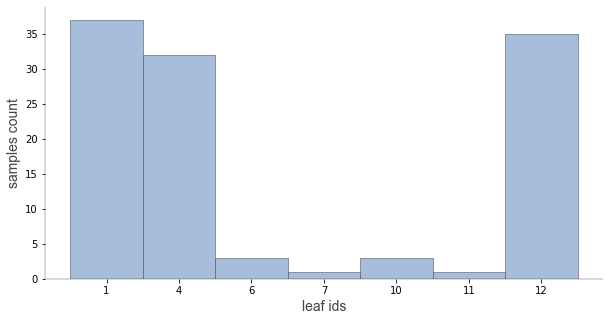

In [14]:
viz_leaf_samples(model, display_type='plot')

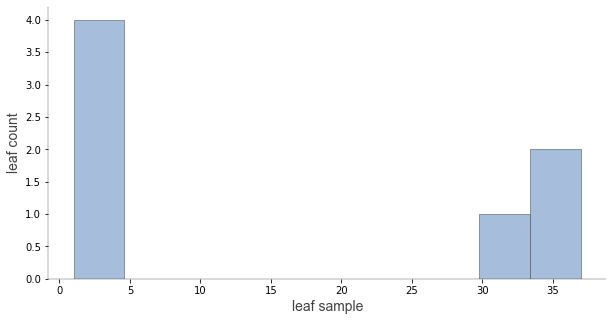

In [15]:
viz_leaf_samples(model, display_type='hist')

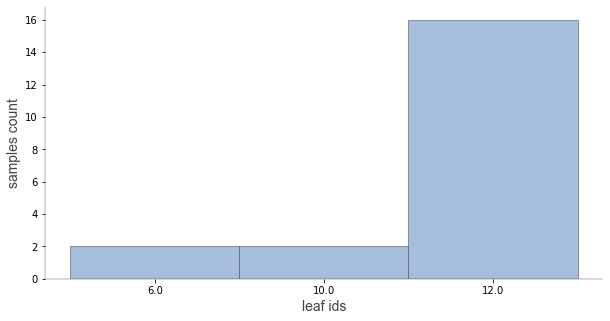

In [16]:
viz_leaf_subsamples(shadow, subsample, display_type='plot')

In [17]:
print(explain_prediction_path(shadow, X_train[0, :], explanation_type="plain_english"))

2.35 <= petal length (cm)  < 4.95
petal width (cm) < 1.65

